<a href="https://colab.research.google.com/github/siddhant0704/Credit-card-fraud-detection/blob/main/Credit-card-Fraud-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Card Fraud Detection in Financial Data**

# **Importing Libraries**

In [ ]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import SelectKBest
from imblearn.combine import SMOTETomek
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn import metrics
sns.set()

# **Loading data and Exploratory Data Analysis**

**Load the given json file and stored it as trans_df dataframe and set lines=True since every new transaction is separated by a line**


In [ ]:
trans_df = pd.read_json('transactions.json', lines=True)
trans_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


**This info() function shows us the different features with it's data type and count of the non-null values**

In [ ]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [ ]:
#Coverting date-time features into datetime data type from it's object data type
trans_df['transactionDateTime'] = trans_df['transactionDateTime'].astype('datetime64[ns]')
trans_df['currentExpDate'] = trans_df['currentExpDate'].astype('datetime64[ns]')
trans_df['accountOpenDate'] = trans_df['accountOpenDate'].astype('datetime64[ns]')
trans_df['dateOfLastAddressChange'] = trans_df['dateOfLastAddressChange'].astype('datetime64[ns]')

In [ ]:
#Coverting bool data type features
trans_df.expirationDateKeyInMatch = trans_df.expirationDateKeyInMatch.replace({True: 1, False: 0})
trans_df.cardPresent = trans_df.cardPresent.replace({True: 1, False: 0})
trans_df.isFraud = trans_df.isFraud.replace({True: 1, False: 0})

In [ ]:
#Now the updated data-type on features can be seen
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             786363 non-null  int64         
 1   customerId                786363 non-null  int64         
 2   creditLimit               786363 non-null  int64         
 3   availableMoney            786363 non-null  float64       
 4   transactionDateTime       786363 non-null  datetime64[ns]
 5   transactionAmount         786363 non-null  float64       
 6   merchantName              786363 non-null  object        
 7   acqCountry                786363 non-null  object        
 8   merchantCountryCode       786363 non-null  object        
 9   posEntryMode              786363 non-null  object        
 10  posConditionCode          786363 non-null  object        
 11  merchantCategoryCode      786363 non-null  object        
 12  cu

In [ ]:
#Checking the different values for data from the front
trans_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,0,,,0,0
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,1,,,0,0
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,0,,,0,0
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,0,,,0,0
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,1,,,0,0


In [ ]:
#Checking the different values for data from the bottom
trans_df.head(-5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.00,,,,0,,,0,0
1,737265056,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.00,,,,1,,,0,0
2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.00,,,,0,,,0,0
3,737265056,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.00,,,,0,,,0,0
4,830329091,830329091,5000,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.00,,,,1,,,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786353,732852505,732852505,50000,49796.87,2016-12-10 12:24:38,190.41,EZ Putt Putt #804489,US,US,09,01,entertainment,2029-06-01,2012-08-23,2012-08-23,936,936,3783,PURCHASE,,203.13,,,,1,,,0,0
786354,732852505,732852505,50000,49606.46,2016-12-10 23:29:11,83.97,KFC #206511,US,US,05,08,fastfood,2030-12-01,2012-08-23,2012-08-23,939,939,3388,PURCHASE,,393.54,,,,1,,,0,0
786355,732852505,732852505,50000,49522.49,2016-12-18 14:06:34,157.22,Uber,US,US,09,01,rideshare,2029-08-01,2012-08-23,2012-08-23,936,936,3783,PURCHASE,,477.51,,,,0,,,0,0
786356,732852505,732852505,50000,49365.27,2016-12-19 03:25:53,408.83,Lyft,US,US,09,01,rideshare,2021-06-01,2012-08-23,2012-08-23,939,939,3388,PURCHASE,,634.73,,,,0,,,0,0


**Gives the statistics like mean, standard deviation, and quartiles for numeric data type features along with minimum and maximum values**

In [ ]:
trans_df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089,0.448734,0.001326,0.015790
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068,0.497365,0.036395,0.124664
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000,0.000000,0.000000,0.000000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000,0.000000,0.000000,0.000000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000,1.000000,0.000000,0.000000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000,1.000000,1.000000,1.000000


**Potrays the number of unique values in each column -> gives us a glimpse into constant columns (only 1 unique values),
binary categories or boolean categories that has 2 unique values,
categorical variables with unique values less than or equal to 10,
and continous variables with significantly higher unique value** 

In [ ]:
trans_df.nunique(axis=0)

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521915
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  4
echoBuffer                       1
currentBalance              487318
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch         2
isFraud             

**Categorical variables - Checking different categories and number of values present in each**

In [ ]:
trans_df.creditLimit.value_counts().sort_values()

500       27097
250       34025
1000      36430
50000     48781
10000     56889
20000     68629
2500      75429
7500      97913
15000    139307
5000     201863
Name: creditLimit, dtype: int64

In [ ]:
trans_df.acqCountry.value_counts().sort_values()

PR       1538
CAN      2424
MEX      3130
         4562
US     774709
Name: acqCountry, dtype: int64

In [ ]:
trans_df.merchantCountryCode.value_counts().sort_values()

          724
PR       1559
CAN      2426
MEX      3143
US     778511
Name: merchantCountryCode, dtype: int64

In [ ]:
trans_df.posEntryMode.value_counts().sort_values()

        4054
80     15283
90     19576
02    195934
09    236481
05    315035
Name: posEntryMode, dtype: int64

In [ ]:
trans_df.posConditionCode.value_counts().sort_values()

         409
99      7533
08    149634
01    628787
Name: posConditionCode, dtype: int64

In [ ]:
trans_df.merchantCategoryCode.value_counts().sort_values()

cable/phone               1382
gym                       2209
food_delivery             6000
furniture                 7432
online_subscriptions     11067
mobileapps               14990
airline                  15412
personal care            18964
health                   19092
auto                     21651
subscriptions            22901
fuel                     23910
hotels                   34097
rideshare                51136
online_gifts             66238
food                     75490
entertainment            80098
fastfood                112138
online_retail           202156
Name: merchantCategoryCode, dtype: int64

**Transactions are divided into 3 types - address, verification, reversal and purchase. For data wrangling - we will use this finding to analyse transactions that are reversed**

In [ ]:
trans_df.transactionType.value_counts().sort_values()

                           698
ADDRESS_VERIFICATION     20169
REVERSAL                 20303
PURCHASE                745193
Name: transactionType, dtype: int64

# **Data Visualisation**

In [ ]:
#Finding discrete features i.e categorical features with unique values ranging from 0 and 10
dataset = trans_df.copy()
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_features if len(dataset[feature].unique())<=10 ]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 4


In [ ]:
print('The discrete features presennt in the dataset is:', discrete_feature)

The discrete features presennt in the dataset is: ['creditLimit', 'cardPresent', 'expirationDateKeyInMatch', 'isFraud']


In [ ]:
#Finding continous features except the categorical features, customerId and accountNumber columns
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature+
                    ['customerId','accountNumber','transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange']]
print("Continuous feature Count :{}".format(len(continuous_feature)))

Continuous feature Count :6


**Plotting distributions to see how the values are lying for each of the feature column-**


1.   availableMoney - It is left skewed showing that most of the customers have a balance of less that 100
2. transactionAmount - It is left skewed showing that most customers are making smaller transactions and there are hardly
transactions above $500
3. cardCVV and enteredCVV - There's a major finding here that shows that the enteredCVV do not have a lot of entries around 0.
Also, two cardCVV ranges are targeted in the enteredCVV column as their bars have risen as compared to the actual cardCVV
currentBalance - The current balance graph is also left skewed showing that the customers do not keep a lot of balance in
their account





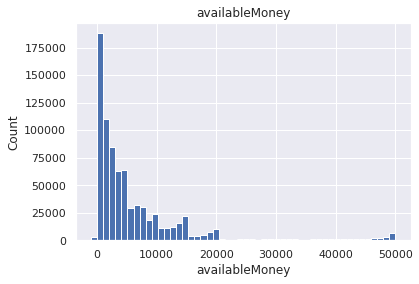

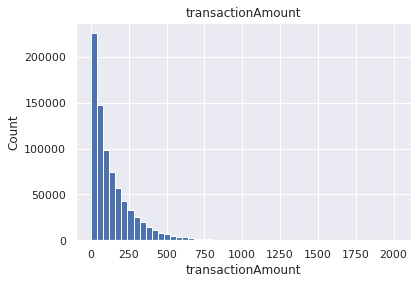

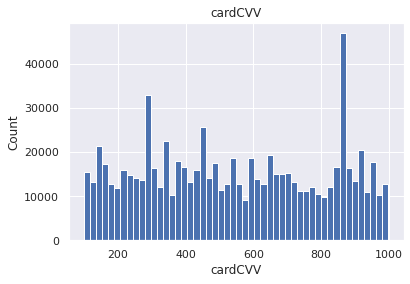

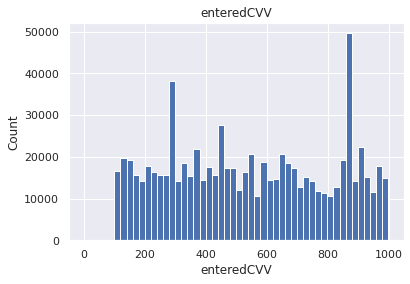

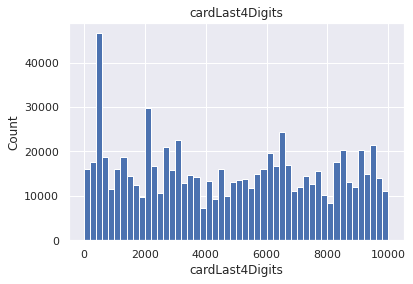

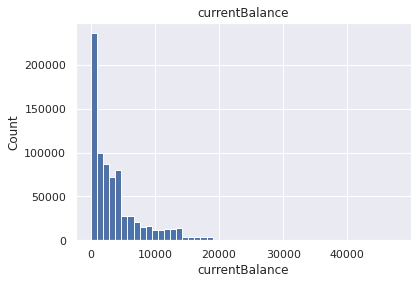

In [ ]:
for feature in continuous_feature:
    data=dataset.copy()
    data[feature].hist(bins=50)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()
    print('\n')

**Hypotheses for transactionAmount column**
1. Left Skewed - maximum transactions are of smaller amounts ranging between 0 and 100
2. The number of transactions are exponentially decreasing as the amount increases
3. Even though there's a good credit limit, there are hardly any greater amount transactions of more than $1000

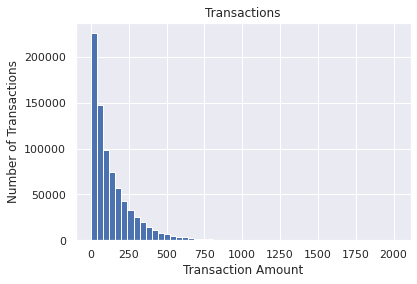

In [ ]:
trans_df['transactionAmount'].hist(bins=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Number of Transactions')
plt.title('Transactions')
plt.show()

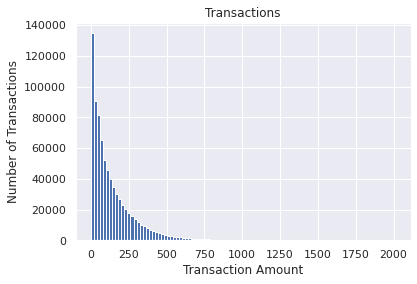

In [ ]:
trans_df['transactionAmount'].hist(bins=100)
plt.xlabel('Transaction Amount')
plt.ylabel('Number of Transactions')
plt.title('Transactions')
plt.show()

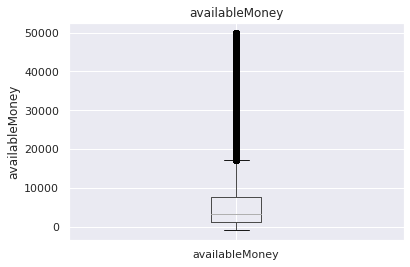

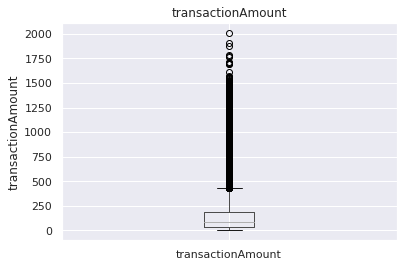

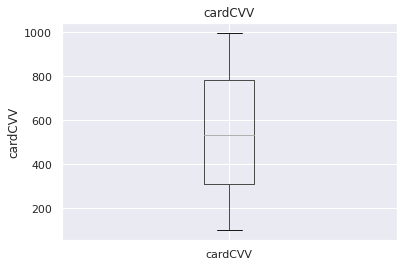

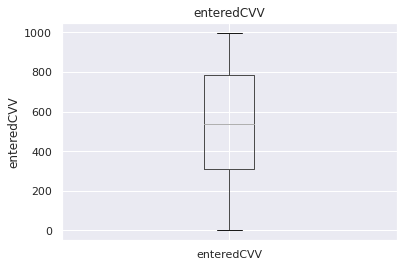

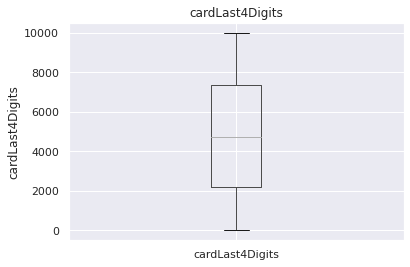

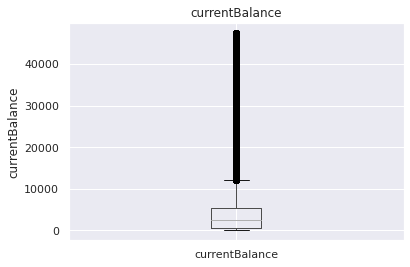

In [ ]:
for feature in continuous_feature:
    data=dataset.copy()
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

**Imbalance in target class - The isFraud column is highly imbalanced as more than 98.4% of the data points are of the
non-fraudulent class whereas only 1.58% of the data points are of the fraudulent class. Keeping this in mind, will have
to do sampling on the data to build an effective model in the steps to follow**

In [ ]:
trans_df['isFraud'].value_counts()/trans_df.shape[0]

0    0.98421
1    0.01579
Name: isFraud, dtype: float64

Text(0, 0.5, 'Frequency')

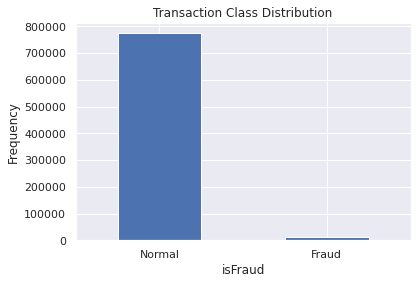

In [ ]:
#Plot to show the above imbalanced class finding
LABELS = ["Normal", "Fraud"]
count_classes = pd.value_counts(trans_df['isFraud'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("isFraud")
plt.ylabel("Frequency")

# **Data Wrangling**

**a. Yes, programmatically reversed and multi-swipe transactions can be identified**

**b. Finding reversal and multiswipe transactions using the given logic -**


1.   Reversal transactions - The transactionType column contains a category for Reversal transactions. Using it, I found out that there are 20303 such transactions amounting to a dollar value of $2.821 Million

2.   Multiswipe transactions - To find multiswipe transactions grouped the data with respect to customerId and applied the logic that there comes more than one entry within the given time frame - 2mins or 5mins then it is marked duplicated. The result from this was that when the timeframe is 2 minutes there were 10,982 transactions with a dollar value of $1472873.8 whereas when the timeframe is 5 minutes there were 18,014 transactions with a dollar value of 2285828.69


**c. One interesting finding in these transactions is the importance of time mapping of transactions - In between 2 mins and 5 mins the transactions got doubled and the money involved became 1.5x times for the latter time mark. So, it is very necessary as to how these transactions are defined and more crucial to keep a track of these transactions as they do not have a direct identifier as the reversal transactions**

In [ ]:
reversal = trans_df.loc[trans_df['transactionType'] == 'REVERSAL', 'transactionAmount'].sum()
reversal_trans = trans_df.loc[trans_df['transactionType'] == 'REVERSAL', 'transactionAmount'].count()

In [ ]:
print('Number of Reversal transactions:',reversal_trans)
print('Total amount in reversal transactions ${}'.format(reversal))

Number of Reversal transactions: 20303
Total amount in reversal transactions $2821792.5


In [ ]:
DF = trans_df.copy()
DF.sort_values(['customerId', 'transactionDateTime'], inplace=True)

m1 = DF.groupby('customerId', sort=False)['transactionAmount'].apply(lambda x: x.duplicated())
m2 = DF.groupby('customerId', sort=False)['transactionDateTime'].diff() <= pd.Timedelta(2, unit='minutes')

DF['Duplicated?'] = np.where(m1 & m2, 'Yes', 'No')
duplicated_trans_2mins = DF['Duplicated?'].value_counts()['Yes']

In [ ]:
duplicated_money_2mins= DF.loc[DF['Duplicated?'] == 'Yes', 'transactionAmount'].sum()

In [ ]:
DF = trans_df.copy()
DF.sort_values(['customerId', 'transactionDateTime'], inplace=True)

m1 = DF.groupby('customerId', sort=False)['transactionAmount'].apply(lambda x: x.duplicated())
m2 = DF.groupby('customerId', sort=False)['transactionDateTime'].diff() <= pd.Timedelta(5, unit='minutes')

DF['Duplicated?'] = np.where(m1 & m2, 'Yes', 'No')
duplicated_trans_5mins = DF['Duplicated?'].value_counts()['Yes']

In [ ]:
duplicated_money_5mins= DF.loc[DF['Duplicated?'] == 'Yes', 'transactionAmount'].sum()

***The significant increase in transactions when we increase the timer clock to 5 minutes from 2 minutes show that there have been multiple instances of multiswipe transactions in different timeframes and mapping it becomes difficult for the bank and the user***

In [ ]:
print('Number of Duplicated transactions:',duplicated_trans_2mins)
print('Total amount in duplicated transactions in 2 mintues: ${}'.format(duplicated_money_2mins))

Number of Duplicated transactions: 10982
Total amount in duplicated transactions in 2 mintues: $1472873.8


In [ ]:
print('Number of Duplicated transactions:',duplicated_trans_5mins)
print('Total amount in duplicated transactions in 2 mintues: ${}'.format(duplicated_money_5mins))

Number of Duplicated transactions: 18014
Total amount in duplicated transactions in 2 mintues: $2285828.69


# **Handling Missing values**

**Checking for null values in the data - It does not indicate or count the empty strings in the data. 
So will have to replace the empty strings first to find the missing values**

In [ ]:
trans_df.count().isna()

accountNumber               False
customerId                  False
creditLimit                 False
availableMoney              False
transactionDateTime         False
transactionAmount           False
merchantName                False
acqCountry                  False
merchantCountryCode         False
posEntryMode                False
posConditionCode            False
merchantCategoryCode        False
currentExpDate              False
accountOpenDate             False
dateOfLastAddressChange     False
cardCVV                     False
enteredCVV                  False
cardLast4Digits             False
transactionType             False
echoBuffer                  False
currentBalance              False
merchantCity                False
merchantState               False
merchantZip                 False
cardPresent                 False
posOnPremises               False
recurringAuthInd            False
expirationDateKeyInMatch    False
isFraud                     False
dtype: bool

In [ ]:
#Replacing empty string values with null value
trans_df = trans_df.replace('', np.nan) 

In [ ]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             786363 non-null  int64         
 1   customerId                786363 non-null  int64         
 2   creditLimit               786363 non-null  int64         
 3   availableMoney            786363 non-null  float64       
 4   transactionDateTime       786363 non-null  datetime64[ns]
 5   transactionAmount         786363 non-null  float64       
 6   merchantName              786363 non-null  object        
 7   acqCountry                781801 non-null  object        
 8   merchantCountryCode       785639 non-null  object        
 9   posEntryMode              782309 non-null  object        
 10  posConditionCode          785954 non-null  object        
 11  merchantCategoryCode      786363 non-null  object        
 12  cu

In [ ]:
trans_df.isnull().values.any()

True

In [ ]:
trans_df.isnull().sum(axis = 0)

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

**Count of null values in different columns -**

*   No null values - 18 columns
*   All null values - 6 columns : Since these columns are empty, they can be dropped
*   Some null values - Since columns consists of null values ranging from [409,4562] - I will drop these rows since it does not add to any significant data (4562/780000 ->0.005) i.e only 0.5% of total data


In [ ]:
trans_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,0,0
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,1,NaN,NaN,0,0
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,0,0
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,0,0
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.0,NaN,NaN,NaN,1,NaN,NaN,0,0


In [ ]:
#Dropping columns that are completly null and empty
trans_df = trans_df.drop(['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'],axis=1)
trans_df = trans_df.reset_index(drop=True)
trans_df.shape

(786363, 23)

In [ ]:
trans_df.isnull().sum(axis = 0)

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

**Dropped data points from acqCountry and merchantCountryCode as they were a part of constant column with negligible standard deviation i.e most values in these two columns indicate a constant value 'US'. Dropped data points from other columns due to lack of domain knowledge and taking into account that they identified a minimal subset (less than 0.5%) in a huge dataset.**

In [ ]:
#Dropping null values/empty values from the dataset
trans_df = trans_df.dropna()
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 776668 entries, 0 to 786362
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   accountNumber             776668 non-null  int64         
 1   customerId                776668 non-null  int64         
 2   creditLimit               776668 non-null  int64         
 3   availableMoney            776668 non-null  float64       
 4   transactionDateTime       776668 non-null  datetime64[ns]
 5   transactionAmount         776668 non-null  float64       
 6   merchantName              776668 non-null  object        
 7   acqCountry                776668 non-null  object        
 8   merchantCountryCode       776668 non-null  object        
 9   posEntryMode              776668 non-null  object        
 10  posConditionCode          776668 non-null  object        
 11  merchantCategoryCode      776668 non-null  object        
 12  cu

# **Feature Engineering**

In [ ]:
trans_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0


In [ ]:
#Dropping the date-time columns to getting the data ready
trans_df = trans_df.drop(['transactionDateTime','accountOpenDate', 'dateOfLastAddressChange', 'currentExpDate'],axis=1)
trans_df = trans_df.reset_index(drop=True)
trans_df.shape

(776668, 19)

**Dropping accountNumber and customerId columns as they are unique identifiers, and do not hold any importance for predicting the target variable**

In [ ]:
trans_df = trans_df.drop(['accountNumber', 'customerId','merchantName'],axis=1)
trans_df = trans_df.reset_index(drop=True)
trans_df.shape

(776668, 16)

In [ ]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776668 entries, 0 to 776667
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   creditLimit               776668 non-null  int64  
 1   availableMoney            776668 non-null  float64
 2   transactionAmount         776668 non-null  float64
 3   acqCountry                776668 non-null  object 
 4   merchantCountryCode       776668 non-null  object 
 5   posEntryMode              776668 non-null  object 
 6   posConditionCode          776668 non-null  object 
 7   merchantCategoryCode      776668 non-null  object 
 8   cardCVV                   776668 non-null  int64  
 9   enteredCVV                776668 non-null  int64  
 10  cardLast4Digits           776668 non-null  int64  
 11  transactionType           776668 non-null  object 
 12  currentBalance            776668 non-null  float64
 13  cardPresent               776668 non-null  i

In [ ]:
#Converting object data-type features into int data type
trans_df['posEntryMode'] = trans_df['posEntryMode'].astype(str).astype(int)
trans_df['posConditionCode'] = trans_df['posConditionCode'].astype(str).astype(int)

**Dropping columns that are having less varaince - acqCountry, merchantCountryCode and are almost constant resulting in no impact on the target variable**

In [ ]:
trans_df.acqCountry.value_counts().sort_values()

PR       1532
CAN      2406
MEX      3110
US     769620
Name: acqCountry, dtype: int64

In [ ]:
trans_df.merchantCountryCode.value_counts().sort_values()

PR       1541
CAN      2399
MEX      3107
US     769621
Name: merchantCountryCode, dtype: int64

In [ ]:
trans_df = trans_df.drop(['acqCountry', 'merchantCountryCode'],axis=1)
trans_df = trans_df.reset_index(drop=True)
trans_df.shape

(776668, 14)

In [ ]:
trans_df.shape

(776668, 14)

**Checking the correlation of different features present and plotting it in a heatmap representation**

In [ ]:
X = trans_df.iloc[:,:]
corr_matrix = X.corr().abs()
corr_matrix

,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,cardCVV,enteredCVV,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
creditLimit,1.000000,0.834845,0.005721,0.000823,0.000144,0.051465,0.051536,0.126154,0.654006,0.003874,0.002353,0.003423
availableMoney,0.834845,1.000000,0.009897,0.000456,0.000538,0.016794,0.016857,0.074539,0.129558,0.002400,0.004229,0.001377
transactionAmount,0.005721,0.009897,1.000000,0.003104,0.000417,0.000457,0.000379,0.001855,0.023906,0.037346,0.001931,0.074359
posEntryMode,0.000823,0.000456,0.003104,1.000000,0.000685,0.002224,0.002326,0.001241,0.000856,0.001144,0.001576,0.007888
posConditionCode,0.000144,0.000538,0.000417,0.000685,1.000000,0.000255,0.000280,0.001309,0.000999,0.001538,0.000776,0.008135
cardCVV,0.051465,0.016794,0.000457,0.002224,0.000255,1.000000,0.996031,0.011751,0.069623,0.045519,0.000493,0.008536
enteredCVV,0.051536,0.016857,0.000379,0.002326,0.000280,0.996031,1.000000,0.011616,0.069665,0.045308,0.000274,0.008503
cardLast4Digits,0.126154,0.074539,0.001855,0.001241,0.001309,0.011751,0.011616,1.000000,0.124804,0.040904,0.002015,0.000752
currentBalance,0.654006,0.129558,0.023906,0.000856,0.000999,0.069623,0.069665,0.124804,1.000000,0.010277,0.001573,0.008059
cardPresent,0.003874,0.002400,0.037346,0.001144,0.001538,0.045519,0.045308,0.040904,0.010277,1.000000,0.040312,0.042761


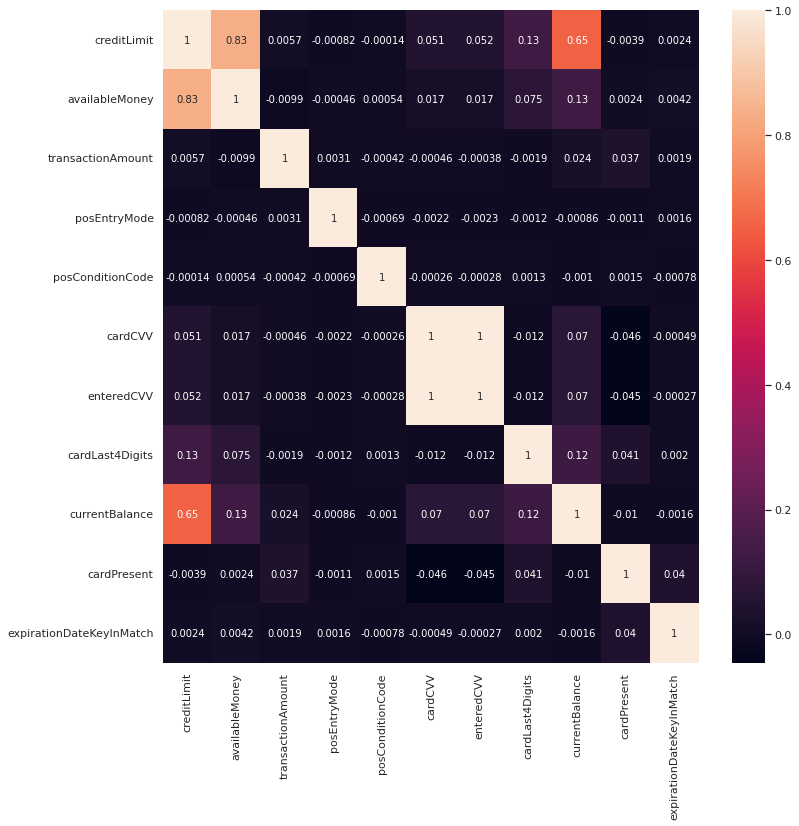

In [ ]:
corr=X.iloc[:,:-1].corr()
top_features=corr.index
plt.figure(figsize=(12,12))
sns.heatmap(X[top_features].corr(),annot=True)

**Dropping cardCVV column, as it is highly correlated to enteredCVV and does not hold a high feature importance**

In [ ]:
trans_df = trans_df.drop(['cardCVV'],axis=1)
trans_df = trans_df.reset_index(drop=True)

In [ ]:
trans_df.shape

(776668, 13)

**Splitting the data to get the features in X and target column in y**

In [ ]:
X = trans_df.iloc[:,:-1]
y = trans_df.iloc[:,-1]

In [ ]:
X.head()

,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,merchantCategoryCode,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch
0,5000,5000.0,98.55,2,1,rideshare,414,1803,PURCHASE,0.0,0,0
1,5000,5000.0,74.51,9,1,entertainment,486,767,PURCHASE,0.0,1,0
2,5000,5000.0,7.47,9,1,mobileapps,486,767,PURCHASE,0.0,0,0
3,5000,5000.0,7.47,9,1,mobileapps,486,767,PURCHASE,0.0,0,0
4,5000,5000.0,71.18,2,1,fastfood,885,3143,PURCHASE,0.0,1,0


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776668 entries, 0 to 776667
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   creditLimit               776668 non-null  int64  
 1   availableMoney            776668 non-null  float64
 2   transactionAmount         776668 non-null  float64
 3   posEntryMode              776668 non-null  int64  
 4   posConditionCode          776668 non-null  int64  
 5   merchantCategoryCode      776668 non-null  object 
 6   enteredCVV                776668 non-null  int64  
 7   cardLast4Digits           776668 non-null  int64  
 8   transactionType           776668 non-null  object 
 9   currentBalance            776668 non-null  float64
 10  cardPresent               776668 non-null  int64  
 11  expirationDateKeyInMatch  776668 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 71.1+ MB


In [ ]:
#Using LabelBinarizer to encode as it results in only one column output after encoding
lb = LabelBinarizer()
X['merchantCategoryCode'] = lb.fit_transform(X['merchantCategoryCode'])
X['transactionType'] = lb.fit_transform(X['transactionType'])
X.head()

,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,merchantCategoryCode,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch
0,5000,5000.0,98.55,2,1,0,414,1803,0,0.0,0,0
1,5000,5000.0,74.51,9,1,0,486,767,0,0.0,1,0
2,5000,5000.0,7.47,9,1,0,486,767,0,0.0,0,0
3,5000,5000.0,7.47,9,1,0,486,767,0,0.0,0,0
4,5000,5000.0,71.18,2,1,0,885,3143,0,0.0,1,0


# **Feature Selection**

**Training ExtraTreesRegressor model to identify important features in the data, and will match with the p-scores ahead using SelectKBest. ExtraTreesRegressor trains quickly and has an inbuilt function to identify the feature importances as it is tree-based model**

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

In [ ]:
print(model.feature_importances_)

[4.01086324e-02 1.90270226e-01 2.47457349e-01 5.51374383e-02
 1.63962320e-02 1.68763127e-03 1.24983306e-01 1.25889243e-01
 3.23727717e-04 1.95240430e-01 2.29395441e-03 2.11831230e-04]


Features in increasing order of their importance on the isFraud Class -



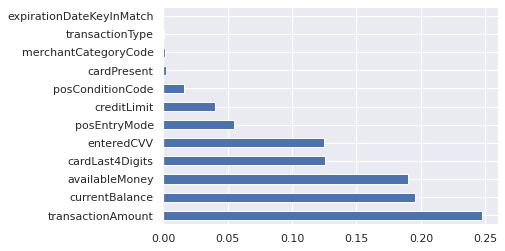

In [ ]:
print('Features in increasing order of their importance on the isFraud Class -\n')
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(12).plot(kind='barh')
plt.show()

**Implementing SelectKBest feature selection technique to identify features that impact the target variable proportionally as compared to the other features based on the p value and score metric**

In [ ]:
ordered_rank_features=SelectKBest(k='all')
ordered_feature=ordered_rank_features.fit(X,y)

In [ ]:
dfscores=pd.DataFrame(ordered_feature.scores_,columns=["Score"])
dfcolumns=pd.DataFrame(X.columns)
features_rank=pd.concat([dfcolumns,dfscores],axis=1)
features_rank.columns=['Features','Score']

**Ordered the features in decreasing order of their scores i.e the more important a feature the higher its rank. This result matches as given by ExtraTreesRegressor model**

In [ ]:
features_rank.nlargest(12,'Score')

,Features,Score
2,transactionAmount,4318.318916
10,cardPresent,1422.728336
5,merchantCategoryCode,342.285564
8,transactionType,127.109986
6,enteredCVV,56.157145
4,posConditionCode,51.403032
9,currentBalance,50.451823
3,posEntryMode,48.333240
0,creditLimit,9.102743
1,availableMoney,1.473580


In [ ]:
scores = ordered_feature.pvalues_
scores

array([2.55234719e-003, 2.24781995e-001, 0.00000000e+000, 3.59886116e-012,
       7.52887304e-013, 2.10663443e-076, 6.69743586e-014, 5.07237455e-001,
       1.76688942e-029, 1.22230371e-012, 4.64044357e-311, 4.76409263e-001])

In [ ]:
feature_select = pd.DataFrame({'variable': X.columns,'pvalue': ordered_feature.pvalues_, 'Score': ordered_feature.scores_ })

**Showing features that are significant based on the p value**

In [ ]:
feature_select[feature_select['pvalue'] < 0.05]

,variable,pvalue,Score
0,creditLimit,2.552347e-03,9.102743
2,transactionAmount,0.000000e+00,4318.318916
3,posEntryMode,3.598861e-12,48.333240
4,posConditionCode,7.528873e-13,51.403032
5,merchantCategoryCode,2.106634e-76,342.285564
6,enteredCVV,6.697436e-14,56.157145
8,transactionType,1.766889e-29,127.109986
9,currentBalance,1.222304e-12,50.451823
10,cardPresent,4.640444e-311,1422.728336


**Dropping features that have very less scores and p value assocaited with them to reduce the dimensionality of the data and to improve training time**

In [ ]:
X = X.drop(['transactionType','expirationDateKeyInMatch','cardLast4Digits','cardPresent'],axis=1)
X = X.reset_index(drop=True)

In [ ]:
X.head()

,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,merchantCategoryCode,enteredCVV,currentBalance
0,5000,5000.0,98.55,2,1,0,414,0.0
1,5000,5000.0,74.51,9,1,0,486,0.0
2,5000,5000.0,7.47,9,1,0,486,0.0
3,5000,5000.0,7.47,9,1,0,486,0.0
4,5000,5000.0,71.18,2,1,0,885,0.0


In [ ]:
X.shape

(776668, 8)

# **Model Building**

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776668 entries, 0 to 776667
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   creditLimit           776668 non-null  int64  
 1   availableMoney        776668 non-null  float64
 2   transactionAmount     776668 non-null  float64
 3   posEntryMode          776668 non-null  int64  
 4   posConditionCode      776668 non-null  int64  
 5   merchantCategoryCode  776668 non-null  int64  
 6   enteredCVV            776668 non-null  int64  
 7   currentBalance        776668 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 47.4 MB


**Performing Oversampling on data using SMOTETOmek since the isFraud is highly imbalanced as mentioned earlier. Now using this technique, enough sample data will be created for the under-represented class i.e isFraud = True class which will in turn train the model in a better way and the model will be able to detect the fraudulent transactions more successfully. I used SMOTETOmek over SMOTE as SMOTETomek gives less noisy data by removing data points from majority class as well unlike SMOTE which in turn gives better classfication results**

In [ ]:
os = SMOTETomek()
X_over, y_over = os.fit_resample(X, y)

In [ ]:
X_over.shape,y_over.shape

((1515426, 8), (1515426,))

**Giving an overview of before oversampling representation of classes vs after oversampling representation of classes in the isFraud class**

In [ ]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_over)))

Original dataset shape Counter({0: 764702, 1: 11966})
Resampled dataset shape Counter({0: 757713, 1: 757713})


**Performed Under Sampling on data to see how much data is lost and there was a reduction of data by more than 95% which is not desirable to adequatley represent the data that is given and would have resulted in poor results**

In [ ]:
rus = RandomUnderSampler(random_state=42, replacement=True) #fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X, y)

print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 764702, 1: 11966})
Resample dataset shape Counter({0: 11966, 1: 11966})


**Splitting the data in Train and Test data. 80% of the data is in Training dataset whereas 20% lies in the Test dataset**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

**Training a logistic regression model - Logistic regression generally works well for binary classification but in this scenario it did not give a very good result owing to the fact that the data is large, complicated resulting in no model convergance to setting a good predictor**

In [ ]:
# define model
lr = LogisticRegression(random_state=13)
lr.fit(X_train,y_train)

LogisticRegression(random_state=13)

In [ ]:
lr_y_pred = lr.predict(X_test)
lr_cm = confusion_matrix(y_test, lr_y_pred)
lr_acc = accuracy_score(y_test, lr_y_pred)
print('Confusion matrix for Logistic Regression:\n',lr_cm)
print('Accuracy of logistic regression:',lr_acc)

Confusion matrix for Logistic Regression:
 [[91998 59441]
 [58782 92865]]
Accuracy of logistic regression: 0.6099357938010994


In [ ]:
lr_ytrain_pred = lr.predict_proba(X_train)
print('LR train roc-auc: {}'.format(roc_auc_score(y_train, lr_ytrain_pred[:,1])))
lr_ytest_pred = lr.predict_proba(X_test)
print('LR test roc-auc: {}'.format(roc_auc_score(y_test, lr_ytest_pred[:,1])))

LR train roc-auc: 0.6452543459799005
LR test roc-auc: 0.6464971732823342


**Training a decision tree model - Decision tree classifier gave a fairly nice prediction since a tree maps out different instances based on each feature and then makes a decision. Having a huge training data set made it a good model but there is a chance that the model has overfitted so will implement random-forest to compensate it**

In [ ]:
dtc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [ ]:
dtc_y_pred = dtc.predict(X_test)
dtc_cm = confusion_matrix(y_test, dtc_y_pred)
dtc_acc = accuracy_score(y_test, dtc_y_pred)
dtc_prec = precision_score(y_test, dtc_y_pred)
dtc_recall = recall_score(y_test, dtc_y_pred)
print('Confusion matrix for Random Forest:\n',dtc_cm)
print('Accuracy of Random Forest:',dtc_acc)
print('Precision of Random Forest:',dtc_prec)
print('Recall of Random Forest:',dtc_recall)

Confusion matrix for Random Forest:
 [[142982   8457]
 [  5044 146603]]
Accuracy of Random Forest: 0.9554548873916974
Precision of Random Forest: 0.9454598220043854
Recall of Random Forest: 0.9667385441189077


In [ ]:
print(classification_report(y_test, dtc_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95    151439
           1       0.95      0.97      0.96    151647

    accuracy                           0.96    303086
   macro avg       0.96      0.96      0.96    303086
weighted avg       0.96      0.96      0.96    303086



**Implenting a XGB Classifier - XGB uses boosting techniques on rees giving an incremental result on the data. It gives an higher weightage to the fraudelent class when identified inccorectly but in this case it did not work well since it overall predicted the fraudalent cases falsely which is not a good choice**

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier()

In [ ]:
xgb_y_pred = xgb.predict(X_test)
xgb_cm = confusion_matrix(y_test, xgb_y_pred)
xgb_acc = accuracy_score(y_test, xgb_y_pred)
xgb_prec = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
print('Confusion matrix for XGB Classifer:\n',xgb_cm)
print('Accuracy of XGB Classifer:',xgb_acc)
print('Precision of XGB Classifer:',xgb_prec)
print('Recall of XGB Classifer:',xgb_recall)

Confusion matrix for XGB Classifer:
 [[134522  16917]
 [ 37701 113946]]
Accuracy of XGB Classifer: 0.8197937219139122
Precision of XGB Classifer: 0.8707274019394329
Recall of XGB Classifer: 0.7513897406476884


In [ ]:
xgb_ytrain_pred = xgb.predict_proba(X_train)
print('XGB train roc-auc: {}'.format(roc_auc_score(y_train, xgb_ytrain_pred[:,1])))
xgb_ytest_pred = xgb.predict_proba(X_test)
print('XGB test roc-auc: {}'.format(roc_auc_score(y_test, xgb_ytest_pred[:,1])))

XGB train roc-auc: 0.9074439923947811
XGB test roc-auc: 0.906740188209308


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


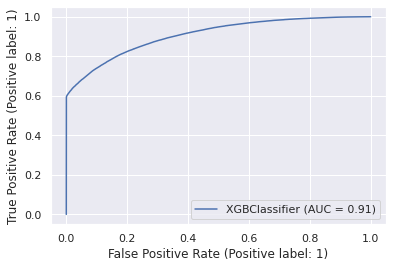

In [ ]:
metrics.plot_roc_curve(xgb, X_test, y_test)
plt.show()

**FINAL MODEL - Training a random forest classification model - Random Forest gave an outstanding result proving that tree based models give good result on imbalanced data set such as ours by creating an ensemble of decision treees and formulating a prediction based on those outputs**

In [ ]:
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [ ]:
rfc_y_pred = rfc.predict(X_test)
rfc_cm = confusion_matrix(y_test, rfc_y_pred)
rfc_acc = accuracy_score(y_test, rfc_y_pred)
rfc_prec = precision_score(y_test, rfc_y_pred)
rfc_recall = recall_score(y_test, rfc_y_pred)
print('Confusion matrix for Random Forest:\n',rfc_cm)
print('Accuracy of Random Forest:',rfc_acc)
print('Precision of Random Forest:',rfc_prec)
print('Recall of Random Forest:',rfc_recall)

Confusion matrix for Random Forest:
 [[147891   3548]
 [  5153 146494]]
Accuracy of Random Forest: 0.9712919765347129
Precision of Random Forest: 0.9763532877460978
Recall of Random Forest: 0.9660197695964972


In [ ]:
print(classification_report(y_test, rfc_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    151439
           1       0.98      0.97      0.97    151647

    accuracy                           0.97    303086
   macro avg       0.97      0.97      0.97    303086
weighted avg       0.97      0.97      0.97    303086



In [ ]:
rfc_ytrain_pred = rfc.predict_proba(X_train)
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, rfc_ytrain_pred[:,1])))
rfc_ytest_pred = rfc.predict_proba(X_test)
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, rfc_ytest_pred[:,1])))

RF train roc-auc: 0.9999893776789724
RF test roc-auc: 0.9937648136384098


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


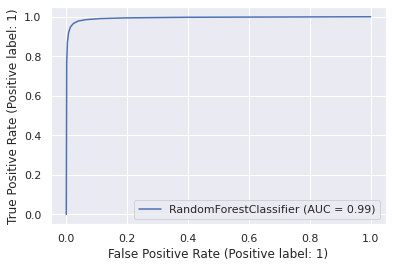

In [ ]:
metrics.plot_roc_curve(rfc, X_test, y_test)
plt.show()

# **Final Results**

Performed Cross Validation on the Random Forest Model to see how the model is performing as a whole on different data folds, it also checks if the model was overfitting on the training data or not - and seeing the results it is performing good on different test folds

In [ ]:
accuracies = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 96.99 %
Standard Deviation: 0.05 %
